In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [6]:
df_indonesia = pd.read_excel("D:/E/PENS/Semester 7/pengembangan aplikasi/Seismie/data/df_indonesia_afterPreprocessing.xlsx")
df_indonesia.head()

,Unnamed: 0,time,latitude,longitude,depth,magnitude,place,source,distance_km,direction,reference_location,country
0,4,2024-12-30T00:43:14.853Z,2.4630,128.1684,55.415,4.1,"83 km NNE of Tobelo, Indonesia",USGS,83,"['NNE', 'Tobelo, Indonesia']",Tobelo,Indonesia
1,5,2024-12-29T06:38:41.963Z,-4.4675,137.0098,9.948,4.1,"172 km NW of Agats, Indonesia",USGS,172,"['NW', 'Agats, Indonesia']",Agats,Indonesia
2,6,2024-12-28T21:55:08.881Z,0.2717,122.0891,141.554,4.6,"112 km WSW of Gorontalo, Indonesia",USGS,112,"['WSW', 'Gorontalo, Indonesia']",Gorontalo,Indonesia
3,8,2024-12-28T06:22:39.391Z,0.3190,129.6915,10.000,4.3,"109 km NW of Waisai, Indonesia",USGS,109,"['NW', 'Waisai, Indonesia']",Waisai,Indonesia
4,9,2024-12-28T05:46:42.954Z,-5.1526,102.4081,34.713,4.5,"150 km S of Bengkulu, Indonesia",USGS,150,"['S', 'Bengkulu, Indonesia']",Bengkulu,Indonesia


DBSCAN Modelling

cluster
 0    52317
-1      141
 1       26
 2        5
Name: count, dtype: int64


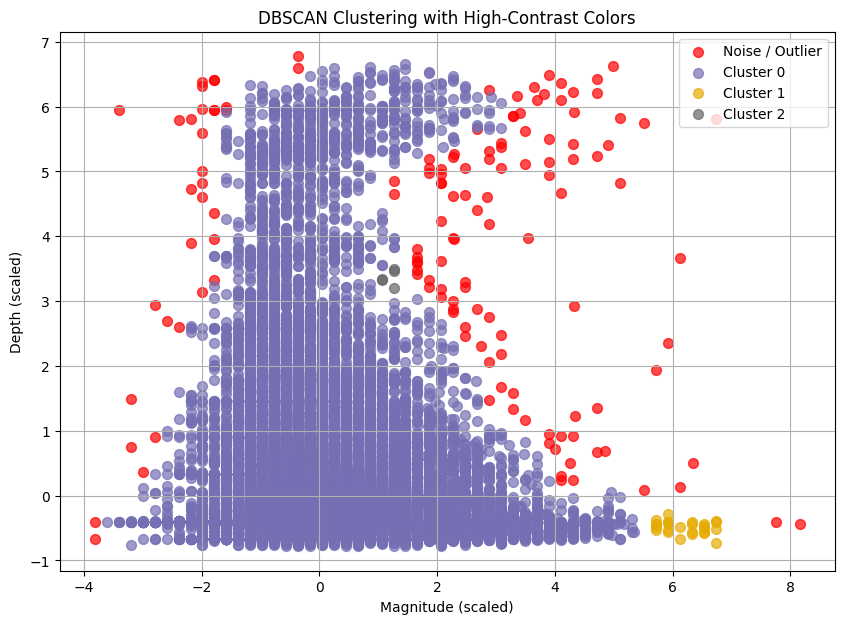

In [7]:
# -------------------------------------
# 1. Ambil dua kolom
# -------------------------------------
X = df_indonesia[['magnitude', 'depth']]

# -------------------------------------
# 2. Normalisasi (StandardScaler)
# -------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------------------
# 3. DBSCAN Clustering
# -------------------------------------
# eps dan min_samples bisa kamu tuning
db = DBSCAN(eps=0.3, min_samples=10)
labels = db.fit_predict(X_scaled)

# simpan hasil cluster ke dataframe
df_indonesia['cluster'] = labels

print(df_indonesia['cluster'].value_counts())

# -------------------------------------
# 4. Plot dengan warna kontras
# -------------------------------------
plt.figure(figsize=(10, 7))

unique_labels = sorted(set(labels))
colors = cm.Dark2(np.linspace(0, 1, len(unique_labels)))  # warna kontras

for label, color in zip(unique_labels, colors):
    cluster_data = X_scaled[labels == label]
    
    if label == -1:
        # warna khusus untuk noise
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
                    c="red", label="Noise / Outlier", alpha=0.7, s=50)
    else:
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
                    color=color, label=f"Cluster {label}", alpha=0.7, s=50)

plt.xlabel("Magnitude (scaled)")
plt.ylabel("Depth (scaled)")
plt.title("DBSCAN Clustering with High-Contrast Colors")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
df_indonesia.to_excel("D:/E/PENS/Semester 7/pengembangan aplikasi/Seismie/data/df_indonesia_cluster.xlsx", 
                      index=False)


Evaluasi Model

In [10]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

score = silhouette_score(X_scaled, labels)
print("Silhouette Score:", score)

dbi = davies_bouldin_score(X_scaled, labels)
print("DBI:", dbi)

Silhouette Score: 0.563240385343527
DBI: 1.7771048607839153


Tuning dengan uji coba

eps=0.05 | Silhouette=0.0384 | DBI=1.7621
eps=0.10 | Silhouette=0.0531 | DBI=1.9661
eps=0.15 | Silhouette=0.0546 | DBI=2.4975
eps=0.20 | Silhouette=0.0606 | DBI=2.6418
eps=0.25 | Silhouette=0.6892 | DBI=0.7628
eps=0.30 | Silhouette=0.5632 | DBI=1.7771
eps=0.35 | Silhouette=0.6967 | DBI=0.7968
eps=0.40 | Silhouette=-1.0000 | DBI=inf
eps=0.45 | Silhouette=-1.0000 | DBI=inf


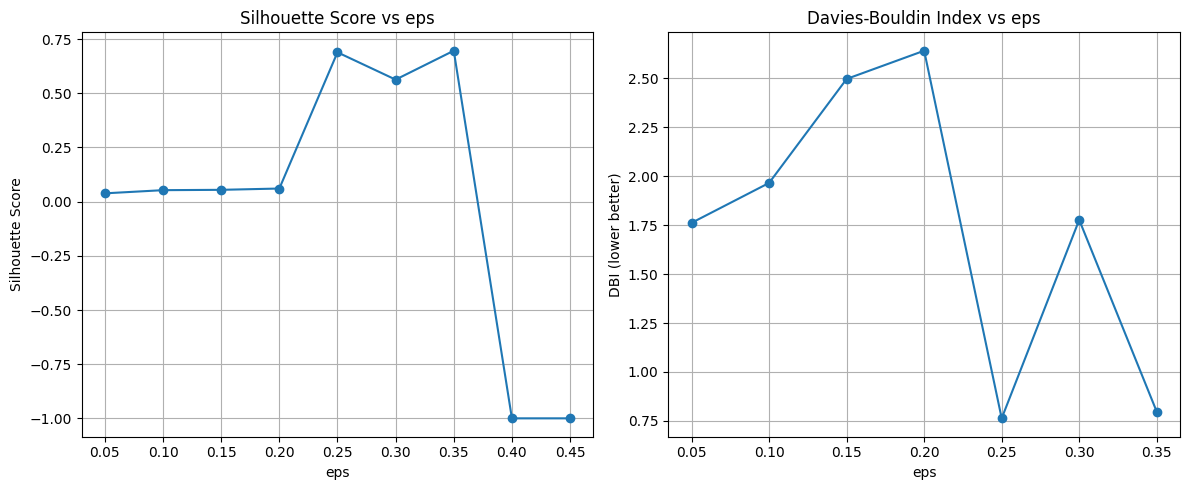


🔍 Hasil Terbaik
Best eps: 0.35000000000000003
Best Silhouette Score: 0.6966841919439247


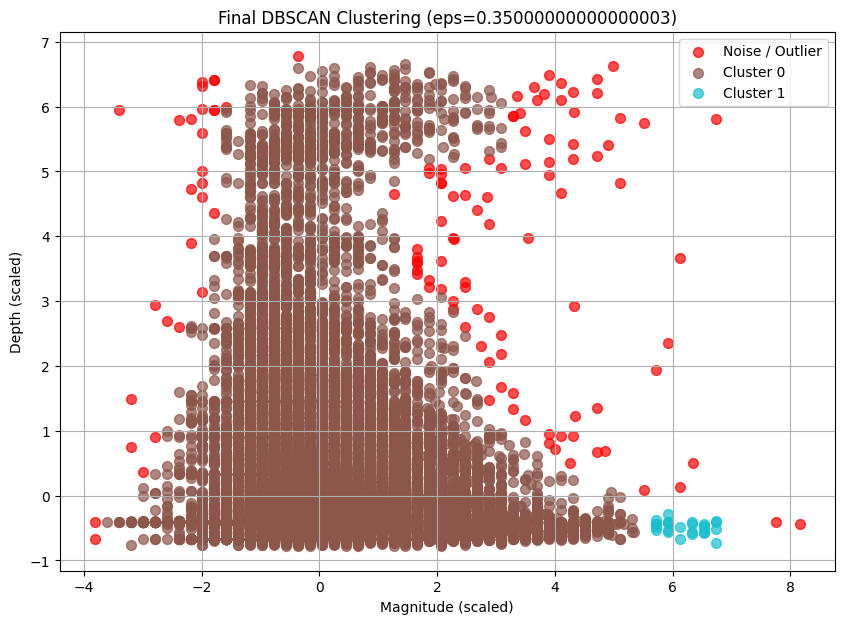

In [12]:
df_indonesia = pd.read_excel("D:/E/PENS/Semester 7/pengembangan aplikasi/Seismie/data/df_indonesia_afterPreprocessing.xlsx")
df_indonesia.head()

# --------------------------------------------------------
# 1. Ambil dua kolom
# --------------------------------------------------------
X = df_indonesia[['magnitude', 'depth']]

# --------------------------------------------------------
# 2. Normalisasi (StandardScaler)
# --------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------------------
# 3. Tuning DBSCAN untuk beberapa nilai eps
# --------------------------------------------------------
eps_values = np.arange(0.05, 0.50, 0.05)
min_samples = 10

sil_scores = []
dbi_scores = []

best_sil = -1
best_eps = None
best_labels = None

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_scaled)

    # Minimal harus ada 2 cluster valid
    if len(set(labels)) > 1 and len(set(labels) - {-1}) > 1:
        sil = silhouette_score(X_scaled, labels)
        dbi = davies_bouldin_score(X_scaled, labels)
    else:
        sil = -1
        dbi = np.inf

    sil_scores.append(sil)
    dbi_scores.append(dbi)

    print(f"eps={eps:.2f} | Silhouette={sil:.4f} | DBI={dbi:.4f}")

    # simpan yang terbaik (silhouette terbesar)
    if sil > best_sil:
        best_sil = sil
        best_eps = eps
        best_labels = labels

# --------------------------------------------------------
# 4. Plot performa tuning (Silhouette & DBI)
# --------------------------------------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(eps_values, sil_scores, marker='o')
plt.title("Silhouette Score vs eps")
plt.xlabel("eps")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(eps_values, dbi_scores, marker='o')
plt.title("Davies-Bouldin Index vs eps")
plt.xlabel("eps")
plt.ylabel("DBI (lower better)")
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n========================")
print("🔍 Hasil Terbaik")
print("========================")
print(f"Best eps: {best_eps}")
print(f"Best Silhouette Score: {best_sil}")

# --------------------------------------------------------
# 5. Clustering Final dengan eps terbaik
# --------------------------------------------------------
df_indonesia["cluster"] = best_labels

# --------------------------------------------------------
# 6. Plot hasil clustering final dengan warna kontras
# --------------------------------------------------------
plt.figure(figsize=(10, 7))

unique_labels = sorted(set(best_labels))
colors = cm.tab10(np.linspace(0, 1, len(unique_labels)))  # warna kontras

for label, color in zip(unique_labels, colors):
    cluster_data = X_scaled[best_labels == label]

    if label == -1:
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1],
                    c="red", label="Noise / Outlier", alpha=0.7, s=50)
    else:
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1],
                    color=color, label=f"Cluster {label}", alpha=0.7, s=50)

plt.xlabel("Magnitude (scaled)")
plt.ylabel("Depth (scaled)")
plt.title(f"Final DBSCAN Clustering (eps={best_eps})")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
df_indonesia.to_excel("D:/E/PENS/Semester 7/pengembangan aplikasi/Seismie/data/best_df_indonesia_cluster.xlsx", 
                      index=False)
